# Introduction

In this tutorial, we picked a dataset from a paper training with GAP, and tune the hyperparameters to improve the training results. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ase.io import read, write
ats = read('fe.xyz', ':') # read all configurations

In [2]:
len(read('fe.xyz', ':'))

12193

In [3]:
!gap_fit at_file=fe.xyz \
gap={soap l_max=3 n_max=8 cutoff=5.0 cutoff_transition_width=1.0 delta=1.0 atom_sigma=0.5 zeta=4 \
     n_sparse=1000 \
     sparse_method=cur_points covariance_type=dot_product} \
sparse_jitter=1e-12 default_sigma={0.005 0.2 1.0 0.0} \
config_type_sigma={slice_sample_high: 0.0001:0.01:0.01:0.0:phonons_54_high:0.001:0.05:1.0:0.0:\
                   phonons_128_high:0.001:0.05:1.0:0.0} e0_method=average

libAtoms::Hello World: 05/09/2019   06:10:14
libAtoms::Hello World: git version  https://github.com/libAtoms/QUIP.git,9c6be05-dirty
libAtoms::Hello World: QUIP_ARCH    linux_x86_64_gfortran_openmp
libAtoms::Hello World: compiled on  Aug  2 2019 at 11:55:40
libAtoms::Hello World: OpenMP parallelisation with 32 threads
libAtoms::Hello World: Random Seed = 22214966
libAtoms::Hello World: global verbosity = 0

Calls to system_timer will do nothing by default


================================ Input parameters ==============================

at_file = fe.xyz
gap = "soap l_max=3 n_max=8 cutoff=5.0 cutoff_transition_width=1.0 delta=1.0 atom_sigma=0.5 zeta=4 n_sparse=1000 sparse_method=cur_points covariance_type=dot_product"
e0 = 0.0
local_property0 = 0.0
e0_offset = 0.0
e0_method = average
default_sigma = "0.005 0.2 1.0 0.0"
sparse_jitter = 1e-12
hessian_delta = 1.0e-2
core_param_file = quip_params.xml
core_ip_args =
energy_parameter_name = energy
local_property_parameter_name = local_propert

TIMER: GP sparsify                                        done in 42840.533116999999 cpu secs, 2495.1986308320002 wall clock secs.

libAtoms::Finalise: 05/09/2019   06:53:15
libAtoms::Finalise: Bye-Bye!


We will use `quip` command to use the potential to predict `energy` and `force` of test configurations. The results are exported to `fe_gap_4.xyz`

In [4]:
! quip E=T F=T atoms_filename=fe.xyz param_filename=gp_new.xml | grep AT | sed 's/AT//' > fe_gap_4.xyz

Using the function and we can visualize the function.

In [5]:
def plot_energy(dft_xyz, gap_xyz):
    """ Plots the distribution of energy per atom on the output vs the input"""
    dft = read(dft_xyz, ':')
    gap = read(gap_xyz, ':')

    e_atom_dft = [at.info['energy'] / len(at) for at in dft]
    e_atom_gap = [at.info['energy'] / len(at) for at in gap]
    # scatter plot of the data
    plt.figure(figsize=[12, 12])
    plt.scatter(e_atom_dft, e_atom_gap, alpha=0.4)
    
    # get the appropriate limits for the plot
    emin = min(min(e_atom_dft), min(e_atom_gap))
    emax = max(max(e_atom_dft), max(e_atom_gap))
    plt.xlim(emin, emax)
    plt.ylim(emin, emax)
    # add line of slope 1 for refrence
    plt.plot([emin, emax], [emin, emax], c='k', linestyle='dashed')
    # set labels
    plt.ylabel('Energy by GAP eV/atom')
    plt.xlabel('Energy by DFT eV/atom')

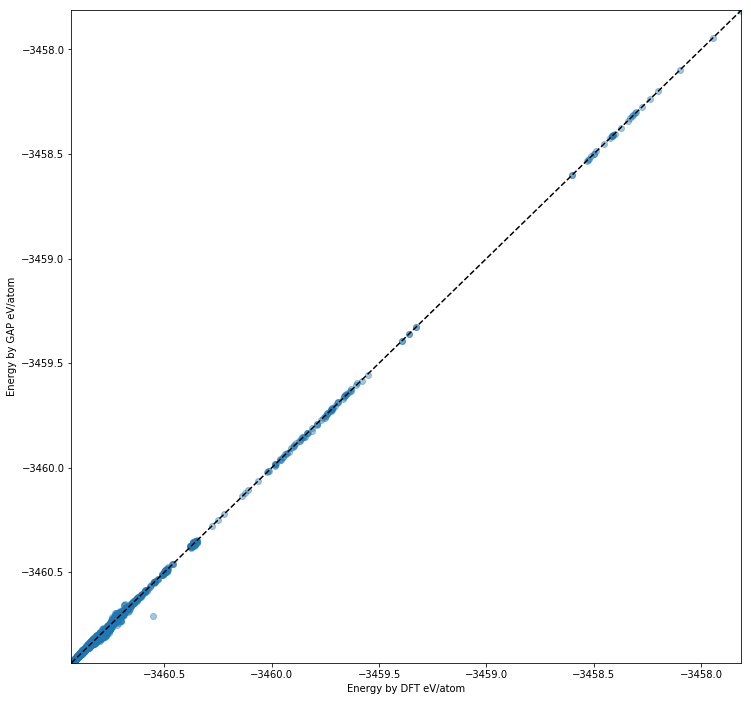

In [6]:
plot_energy('fe.xyz', 'fe_gap_4.xyz')

In [60]:
def plot_force(dftxyz, gapxyz, Z_species):
    """ Plots the distribution of firce components per atom on the output vs the input
    only plots for the given atom type(s)"""
    dft = read(dftxyz, ':')
    gap = read(gapxyz, ':')

    # convert to np arrays, much easier to work with
    f_dft = np.array([at.arrays['force'] for at in dft if at.numbers[0] == Z_species])
    f_gap = np.array([at.arrays['force'] for at in gap if at.numbers[0] == Z_species])
        
    f_dft_all_Z = [np.vstack([f_dft[i] for i, at in enumerate(dft)])]
    f_gap_all_Z = [np.vstack([f_gap[i] for i, at in enumerate(gap)])]         
    f_dft_Z = f_dft_all_Z[0]
    f_gap_Z = f_gap_all_Z[0]
                           
    # scatter plot of the data
    plt.figure(figsize=[12, 12])
    plt.scatter(np.ravel(f_dft_Z), np.ravel(f_gap_Z), alpha=0.4)
    fmax, fmin = max(np.ravel([f_dft_Z, f_gap_Z])), min(np.ravel([f_dft_Z, f_gap_Z]))
    # set labels
    plt.ylabel('Force by GAP / $(eV/\AA)$')
    plt.xlabel('Force by DFT / $(eV/\AA)$')
    plt.grid()
    plt.xlim(fmin, fmax)
    plt.ylim(fmin, fmax)
    plt.plot([fmin, fmax], [fmin, fmax], c='k', linestyle='dashed')
    plt.show()

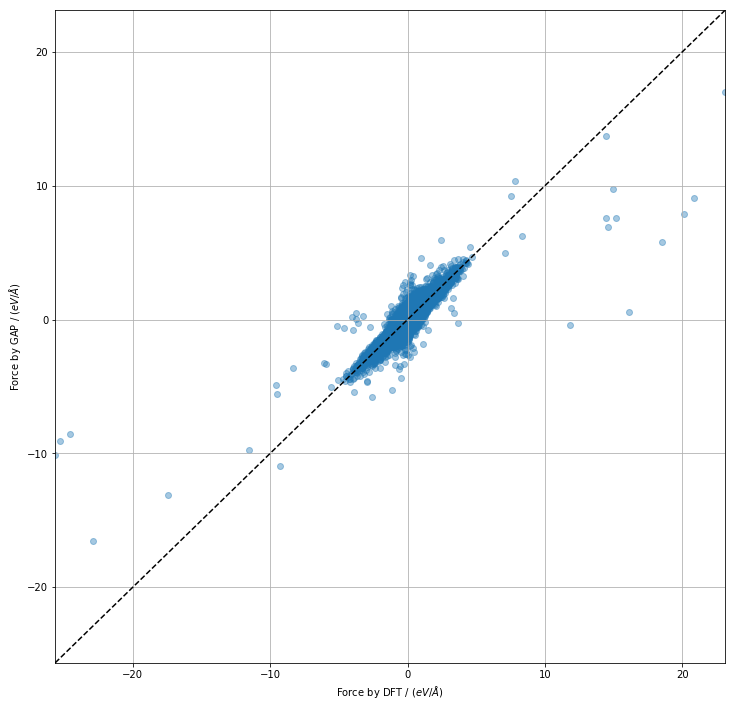

In [61]:
plot_force('fe.xyz', 'fe_gap_4.xyz', [26])